# Trabajo 4 : Procesamiento de lenguaje natural

Se ha escogido trabajar sobre el el proyecto numero 3 de procesamiento de lenguaje natural


## Dataset: The Multilingual Amazon Reviews Corpus

Se puede encontrar el dataset [aquí](https://github.com/kang205/SASRec) y su [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt).

El conjunto de datos contiene comentarios en español, recopiladas entre el 1 de noviembre de 2015 y el 1 de noviembre de 2019. Y además, presenta las siguientes características:

- `review_id`: ID del comentario.
- `product_id`: ID del producto.
- `reviewer_id`: ID de un revisor.
- `stars`: número de estrellas asignadas al comentario.
- `review_body`: texto del comentario.
- `review_title`: título del comentario.
- `language`: idioma del comentario.
- `product_category`: categoría general del producto.

El objetivo del proyecto fue implementar un modelo que dependiendo de la crítica de un producto, asigne la cantidad de estrellas correspondiente. La calificacion es entre el rango 1-5
Ahora el objetivo es realizar las soluciones sugeridas en el anterior proyecto, con el fin de mejorar los resultados de las metricas obtenidas:
- Lematizar con la libreria Stanza
- Realizar Topic Modeling para ver los topicos del dataset y comparar con las palabras mas usadas de los comentarios por estrella, para esto realizaremos LDA. Pregunta: ¿Los topicos mas comentados, tienen relacion con las estrellas asignadas ?
- Utilizar una red neuronal para el analisis de texto, intentando mejorar la metrica seleccionada al utilizar deep learning
- El objetivo cuantificable es superar la metrica del anterior trabajo (Accuracy = 0.5268)

## Importamos librerias y datasets (contamos con dos de prueba de 5000 instancias y uno definitivo de 200000 instancias)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import nltk
import re
from nltk.util import ngrams
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
nltk.download('punkt')
nltk.download('wordnet')
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from unicodedata import normalize
from nltk.corpus import wordnet as wn
from nltk.util import ngrams
from nltk.stem import SnowballStemmer
spanish_stemmer = SnowballStemmer('spanish')
#nlp = spacy.load("es_core_news_sm")

In [3]:
dataset2 = pd.read_json('Dataset_es_dev.json', lines=True)
dataset2

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty
...,...,...,...,...,...,...,...,...
4995,es_0179515,product_es_0158275,reviewer_es_0273644,5,Me ha encantado la cesta. Ha llegado impecable...,guadalupe,es,home
4996,es_0894902,product_es_0953259,reviewer_es_0153773,5,Desempeña su función correctamente,calidad precio,es,camera
4997,es_0760496,product_es_0731995,reviewer_es_0171091,5,Me ha encantado la diadema! Las flores son tal...,Excelente,es,toy
4998,es_0178380,product_es_0402051,reviewer_es_0686937,5,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,es,wireless


In [4]:
dataset1 = pd.read_json('Dataset_es_test.json', lines=True)
dataset1

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0038754,product_es_0113523,reviewer_es_0580071,1,no me llego el articulo me lo mando por correo...,no me llego,es,wireless
1,es_0748979,product_es_0017036,reviewer_es_0819733,1,"la mensajería horrible, no compro mas",amazon sigue sin cumplir en las entregas,es,home
2,es_0411746,product_es_0138642,reviewer_es_0508607,1,Estoy muy decepcionado con el vendedor ya que ...,ESTAFA EN EL ENVÍO,es,toy
3,es_0786686,product_es_0170887,reviewer_es_0491157,1,Mi valoración no es sobre el producto sino sob...,Estafa de Amazon,es,home
4,es_0429700,product_es_0710642,reviewer_es_0008745,1,Pues tenía interés en este libro y probé la ve...,No conseguí pasar de la portada en Kindle,es,digital_ebook_purchase
...,...,...,...,...,...,...,...,...
4995,es_0685611,product_es_0919143,reviewer_es_0461769,5,Para lo que cuesta es perfecto porque cumple s...,Perfectos para lo que sirven,es,wireless
4996,es_0638242,product_es_0636134,reviewer_es_0214562,5,"Material muy flexible y cómodo, acorde a la de...","Buen vendedor, rápido y fiable.",es,wireless
4997,es_0760108,product_es_0078583,reviewer_es_0043609,5,Se ve bien el grabado,medallas con bonito grabado,es,home
4998,es_0070806,product_es_0359350,reviewer_es_0258717,5,lo compré para mi bici pero finalmente se lo h...,timbre,es,sports


In [5]:
dataset = pd.read_json('Dataset_es_train.json', lines=True)
dataset

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes
...,...,...,...,...,...,...,...,...
199995,es_0715276,product_es_0317036,reviewer_es_0643604,5,Mando funciona perfectamente y cumple con toda...,Tal y como se describe,es,electronics
199996,es_0085190,product_es_0622919,reviewer_es_0466173,5,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente,es,electronics
199997,es_0484496,product_es_0358101,reviewer_es_0330744,5,Buena calidad. Satisfecha con la compra.,Buena calidad.,es,apparel
199998,es_0930141,product_es_0788855,reviewer_es_0694290,5,Perfecto para el cumple de mi hijo,Recomendado,es,toy


## Definimos el primer dataset para trabajar, usaremos el de 200000 instancias

In [6]:
df_base= dataset2.copy()
df_base= dataset2.dropna()
df_base= dataset2.reset_index()
df_base.head()

,index,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


In [7]:
dataset.shape

(200000, 8)

### Concatemos las columnas de titulos, comentarios y categoria de producto para trabajar, a esta variables la llamamos "text_concat"

In [8]:
dataset["text_concat"] = dataset["review_title"] + " " + dataset["review_body"] + " " + dataset["product_category"]

In [9]:
dataset.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,text_concat
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics,television Nevir Nada bueno se me fue ka panta...
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics,Dinero tirado a la basura con esta compra Horr...
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore,solo llega una unidad cuando te obligan a comp...
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless,PRODUCTO NO RECIBIDO. No entro en descalificar...
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes,Devuelto Llega tarde y co la talla equivocada ...


### Eliminamos las columnas que no son de interes para trabajar

In [10]:
dataset=dataset.drop(columns=["product_category","language","product_id","reviewer_id","review_body","review_title"])

In [11]:
dataset.head()

,review_id,stars,text_concat
0,es_0491108,1,television Nevir Nada bueno se me fue ka panta...
1,es_0869872,1,Dinero tirado a la basura con esta compra Horr...
2,es_0811721,1,solo llega una unidad cuando te obligan a comp...
3,es_0359921,1,PRODUCTO NO RECIBIDO. No entro en descalificar...
4,es_0068940,1,Devuelto Llega tarde y co la talla equivocada ...


## Procederemos a realizar Top Modeling para descubrir los topicos que se presentan en los comentarios del dataset

In [ ]:
Link de apoyo: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

Para poder hacerlo antes haremos un preprocesamiento de datos similar al del trabajo 3, en el cual se lematizaran las palabras y se las llevara a su raiz, se quitaran las stopwords y las palabras que contengan menos de 3 letras. Se utilizara GENSIM

In [12]:
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess

Definimos las funciones para trabajar

In [13]:
stemmer = SnowballStemmer('spanish')
     
    # Extracto de lematización, restauración de parte del discurso
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
     
     #Filtrar stopwords y palabras de menos de 3
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

Vemos como quedan las palabras con el preprocesamiento

In [14]:
processed_docs = dataset['text_concat'].map(preprocess)
processed_docs[:10]

0    [television, nev, nad, buen, pantall, men, mes...
1    [diner, tir, basur, esta, compr, horribl, tuv,...
2    [sol, lleg, unid, cuand, oblig, compr, oblig, ...
3    [product, recib, entro, descalific, vendedor, ...
4            [devuelt, lleg, tard, tall, equivoc, sho]
5    [jamas, lleg, jamas, lleg, vendedor, nunc, con...
6    [horror, paragu, mal, calid, sensacion, romp, ...
7    [poc, funcional, tuv, devolv, porqu, triangul,...
8    [lleg, estoy, esper, despu, protest, vari, vec...
9    [mal, calid, defectu, defectu, aparient, bien,...
Name: text_concat, dtype: object

## BAG OF WORDS: método que se utiliza en el procesado del lenguaje para representar documentos ignorando el orden de las palabras. 

Creamos un diccionario que contenga el numero de veces que aparecen las palabras en el documento

In [15]:
dictionary = gensim.corpora.Dictionary(processed_docs)
for i in range(10):
    print(i,dictionary[i])
print('number of total words:',len(dictionary))

0 buen
1 electronics
2 fabric
3 men
4 mes
5 nad
6 nev
7 pantall
8 recib
9 respuest
number of total words: 22410


In [16]:
for i in range(10):
    print(i,dictionary.dfs[i])

0 47790
1 10385
2 1541
3 7419
4 5975
5 15898
6 19
7 5764
8 6068
9 816


Ahora usaremos la funcion doc2bow y veremos una lista donde figura el numero de identificador de la palabra y las veces que aparece

In [17]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
print(processed_docs[0])
print(bow_corpus[0])

['television', 'nev', 'nad', 'buen', 'pantall', 'men', 'mes', 'recib', 'respuest', 'fabric', 'electronics']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]


## TFIDF

Con tfidf pse puede analizar la importancia que tienen ciertas palabras de un texto.
- Las siglas TF provienen de la expresión en inglés Term Frequency, Frecuencia de término en español, y determina la frecuencia relativa de un término específico, una palabra o una combinación de palabras, en un documento. Este valor se compara con la frecuencia relativa de todos los demás términos de un texto, documento o sitio web
- El término IDF proviene del inglés Inverse Document Frequency y significa Frecuencia Inversa de Documento. Esta segunda parte de la fórmula completa el análisis de evaluación de los términos y actúa como el corrector del TF. La Frecuencia Inversa de Documento es muy importante ya que incluye en el cálculo la frecuencia de documento de términos específicos: compara el número de todos los documentos disponibles con el número de documentos que contienen el término

In [18]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
for doc in corpus_tfidf:
    print(doc)
    break

[(0, 0.0902079025563399), (1, 0.1863993925251662), (2, 0.3066301505451834), (3, 0.20759292197156243), (4, 0.22123344293365854), (5, 0.15956510476464705), (6, 0.5836339437831678), (7, 0.2234990316237798), (8, 0.22026015837261012), (9, 0.3466941838924091), (10, 0.43162933101439815)]


## LDA: Tecnica para clasificar texto de un documento en topicos particulares

Link de apoyo : http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/

## Lo entrenaremos usando Bag of words

In [19]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=2, workers=2)

Veremos para cada topico las palabras con su peso relativo

In [20]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.037*"lleg" + 0.033*"product" + 0.027*"perfect" + 0.021*"tod" + 0.020*"compr" + 0.017*"rap" + 0.016*"envi" + 0.015*"com" + 0.014*"buen" + 0.011*"esper"
Topic: 1 
Words: 0.068*"buen" + 0.054*"calid" + 0.039*"preci" + 0.021*"par" + 0.020*"bien" + 0.017*"per" + 0.015*"compr" + 0.013*"hom" + 0.013*"product" + 0.010*"esta"
Topic: 2 
Words: 0.065*"par" + 0.025*"bien" + 0.018*"per" + 0.016*"perfect" + 0.015*"pequeñ" + 0.014*"comod" + 0.011*"esta" + 0.011*"much" + 0.011*"encant" + 0.011*"bonit"
Topic: 3 
Words: 0.039*"funcion" + 0.023*"buen" + 0.021*"bien" + 0.020*"par" + 0.016*"per" + 0.015*"cumpl" + 0.014*"perfect" + 0.013*"electronics" + 0.012*"compr" + 0.012*"tien"
Topic: 4 
Words: 0.044*"wireless" + 0.025*"perfect" + 0.022*"bien" + 0.021*"buen" + 0.021*"fund" + 0.019*"par" + 0.018*"book" + 0.016*"libr" + 0.016*"tod" + 0.013*"pantall"


### Probamos como clasificaria nuestro modelo a un texto determinado, es decir en que topico quedaria

In [21]:
docId=90

In [22]:
print(dataset['text_concat'][docId])
print(processed_docs[docId])
print('-------------------------------------')
for index, score in sorted(lda_model[bow_corpus[docId]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic{}: {}".format(score,index, lda_model.print_topic(index, 10)))

Fatal Ha llegado con solo 1 tornillo valla estafa sports
['fatal', 'lleg', 'sol', 'tornill', 'vall', 'estaf', 'sport']
-------------------------------------

Score: 0.6360284686088562	 
Topic0: 0.037*"lleg" + 0.033*"product" + 0.027*"perfect" + 0.021*"tod" + 0.020*"compr" + 0.017*"rap" + 0.016*"envi" + 0.015*"com" + 0.014*"buen" + 0.011*"esper"

Score: 0.2879686951637268	 
Topic2: 0.065*"par" + 0.025*"bien" + 0.018*"per" + 0.016*"perfect" + 0.015*"pequeñ" + 0.014*"comod" + 0.011*"esta" + 0.011*"much" + 0.011*"encant" + 0.011*"bonit"

Score: 0.025496838614344597	 
Topic3: 0.039*"funcion" + 0.023*"buen" + 0.021*"bien" + 0.020*"par" + 0.016*"per" + 0.015*"cumpl" + 0.014*"perfect" + 0.013*"electronics" + 0.012*"compr" + 0.012*"tien"

Score: 0.025329289957880974	 
Topic1: 0.068*"buen" + 0.054*"calid" + 0.039*"preci" + 0.021*"par" + 0.020*"bien" + 0.017*"per" + 0.015*"compr" + 0.013*"hom" + 0.013*"product" + 0.010*"esta"

Score: 0.025176692754030228	 
Topic4: 0.044*"wireless" + 0.025*"perfec

In [ ]:
Aqui podemos ver segun nuestro modelo, el comentario seleccionado se incluye mas en el topico 0 por el peso de sus palabras

# Palabras de los 5 topicos (en nube)

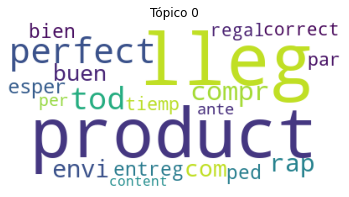

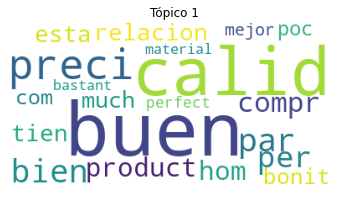

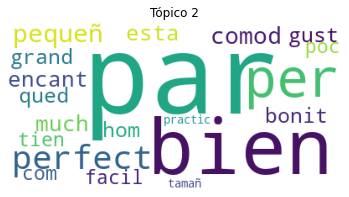

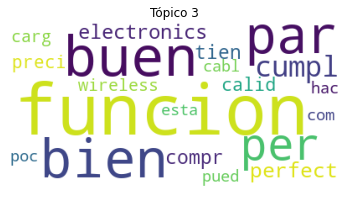

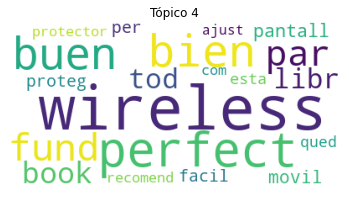

In [23]:
for i in range(0, 5):
    plt.figure()
    plt.imshow(WordCloud(background_color='white', prefer_horizontal=1.0)
               .fit_words(dict(lda_model.show_topic(i, 20))))
    plt.axis("off")
    plt.title("Tópico " + str(i))
    plt.show()

# Veremos la frecuencia de palabras en base a estrellas, como hicimos en el proyecto anterior

### Dividiremos el dataset en funcion a las estrellas de los comentarios para ver la palabras con mayor frecuencia en cada uno, quitaremos las stopwords y las veremos en nubes de palabras

In [24]:
#Definimos las stopwords con nltk
stopwords = nltk.corpus.stopwords.words('spanish')

In [25]:
#Considermos incluir al listado de stopwords de nltk algunas palabras sin su acento.
stopwords_sin_acentos =  ['si', 'tambien', 'que', 'el', 'mio', 'mia', 'mios', 'mias', 'estas', 'esta', 'estamos', 'estais', 'estan', 'esta', 'estes', 
                         'esteis', 'esten', 'estare', 'estaras', 'estara', 'estareis', 'estaran', 'estaria', 'estarias', 'estariamos', 'estariais', 
                         'estarian', 'estuvieramos', 'estuviesemos', 'habeis',  'hayais','habre', 'habras', 'habra', 'habreis', 'habran',
                         'habria', 'habrias', 'habriamos', 'habriais', 'habrian', 'habia', 'habias', 'habiamos', 'habiais', 'habian', 'hubieramos', 
                         'hubiesemos', 'seais', 'sere', 'seras', 'sera', 'sereis', 'seran', 'seria', 'serias', 'seriamos', 'seriais', 'serian', 
                         'eramos', 'fueramos','fuesemos', 'teneis', 'tengais', 'tendre', 'tendras', 'tendra', 'tendreis', 'tendran', 'tendria', 'tendrias',
                         'tendriamos', 'tendriais', 'tendrian', 'tenia', 'tenias', 'teniamos', 'teniais', 'tenian', 'tuvieramos', 'tuviesemos']

In [26]:
#Definimos nuevas stopwords
stopwords_es = stopwords + stopwords_sin_acentos

In [150]:
ds_onestar = dataset[dataset.stars==1]
ds_twostar = dataset[dataset.stars==2]
ds_threestar = dataset[dataset.stars==3]
ds_fourstar = dataset[dataset.stars==4]
ds_fivestar = dataset[dataset.stars==5]

## Una estrella

In [151]:
stopwords_cloud = ['Word','Frequency']

In [152]:
#wordcloud_one = WordCloud().generate(str(ds_onestar.iloc[:20]))

Populating the interactive namespace from numpy and matplotlib


(-0.5, 399.5, 199.5, -0.5)

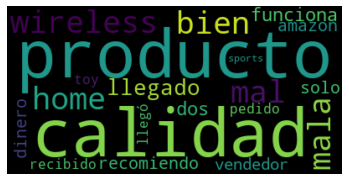

In [153]:
from nltk.tokenize import RegexpTokenizer
onestar = []
for i in range(ds_onestar.shape[0]):
    review = ds_onestar.text_concat.iloc[i] #seleccionar el comentario
    review = review.lower()
    review = RegexpTokenizer('\w+').tokenize(review) # Tokenizar con RegexpTokenizer
    review = [palabra for palabra in review if not palabra in stopwords_es] # Filtrar por stopwords
    onestar.append(review) #agregar el resultado a la lista
import itertools
from itertools import chain
df_one = list(itertools.chain(*onestar))
freqr = nltk.FreqDist(palabra for palabra in df_one)
df_one = pd.DataFrame(list(freqr.items()), columns = ["Word","Frequency"])
df_one=df_one.sort_values('Frequency', ascending=False)
wordcloud_one = WordCloud(stopwords = stopwords_cloud).generate(str(df_one.iloc[:20]))
nube_one = %pylab inline
import matplotlib.pyplot as plt
plt.imshow(wordcloud_one, interpolation='bilinear')
plt.axis("off")

## Dos estrellas

Populating the interactive namespace from numpy and matplotlib


(-0.5, 399.5, 199.5, -0.5)

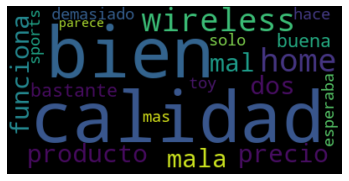

In [154]:
from nltk.tokenize import RegexpTokenizer
twostar = []
for i in range(ds_twostar.shape[0]):
    review = ds_twostar.text_concat.iloc[i] #seleccionar el comentario
    review = review.lower()
    review = RegexpTokenizer('\w+').tokenize(review) # Tokenizar con RegexpTokenizer
    review = [palabra for palabra in review if not palabra in stopwords_es] # Filtrar por stopwords
    twostar.append(review) #agregar el resultado a la lista
import itertools
from itertools import chain
df_two = list(itertools.chain(*twostar))
freqr = nltk.FreqDist(palabra for palabra in df_two)
df_two = pd.DataFrame(list(freqr.items()), columns = ["Word","Frequency"])
df_two=df_two.sort_values('Frequency', ascending=False)
wordcloud_two = WordCloud(stopwords = stopwords_cloud).generate(str(df_two.iloc[:20]))
nube_two = %pylab inline
import matplotlib.pyplot as plt
plt.imshow(wordcloud_two, interpolation='bilinear')
plt.axis("off")

## Tres estrellas

Populating the interactive namespace from numpy and matplotlib


(-0.5, 399.5, 199.5, -0.5)

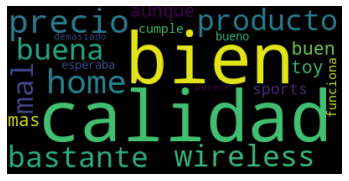

In [155]:
from nltk.tokenize import RegexpTokenizer
threestar = []
for i in range(ds_threestar.shape[0]):
    review = ds_threestar.text_concat.iloc[i] #seleccionar el comentario
    review = review.lower()
    review = RegexpTokenizer('\w+').tokenize(review) # Tokenizar con RegexpTokenizer
    review = [palabra for palabra in review if not palabra in stopwords_es] # Filtrar por stopwords
    threestar.append(review) #agregar el resultado a la lista
import itertools
from itertools import chain
df_three = list(itertools.chain(*threestar))
freqr = nltk.FreqDist(palabra for palabra in df_three)
df_three = pd.DataFrame(list(freqr.items()), columns = ["Word","Frequency"])
df_three=df_three.sort_values('Frequency', ascending=False)
wordcloud_three = WordCloud(stopwords = stopwords_cloud).generate(str(df_three.iloc[:20]))
nube_three = %pylab inline
import matplotlib.pyplot as plt
plt.imshow(wordcloud_three, interpolation='bilinear')
plt.axis("off")

## Cuatro estrellas

Populating the interactive namespace from numpy and matplotlib


(-0.5, 399.5, 199.5, -0.5)

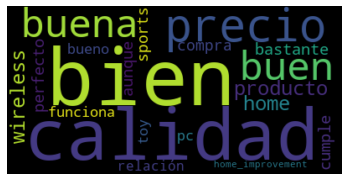

In [157]:
from nltk.tokenize import RegexpTokenizer
fourstar = []
for i in range(ds_fourstar.shape[0]):
    review = ds_fourstar.text_concat.iloc[i] #seleccionar el comentario
    review = review.lower()
    review = RegexpTokenizer('\w+').tokenize(review) # Tokenizar con RegexpTokenizer
    review = [palabra for palabra in review if not palabra in stopwords_es] # Filtrar por stopwords
    fourstar.append(review) #agregar el resultado a la lista
import itertools
from itertools import chain
df_four = list(itertools.chain(*fourstar))
freqr = nltk.FreqDist(palabra for palabra in df_four)
df_four = pd.DataFrame(list(freqr.items()), columns = ["Word","Frequency"])
df_four=df_four.sort_values('Frequency', ascending=False)
wordcloud_four = WordCloud(stopwords = stopwords_cloud).generate(str(df_four.iloc[:20]))
nube_four=%pylab inline
import matplotlib.pyplot as plt
plt.imshow(wordcloud_four, interpolation='bilinear')
plt.axis("off")

## Cinco estrellas

Populating the interactive namespace from numpy and matplotlib


(-0.5, 399.5, 199.5, -0.5)

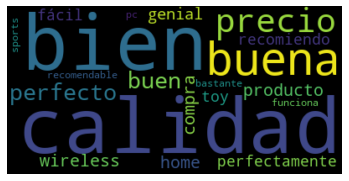

In [159]:
from nltk.tokenize import RegexpTokenizer
fivestar = []
for i in range(ds_fivestar.shape[0]):
    review = ds_fivestar.text_concat.iloc[i] #seleccionar el comentario
    review = review.lower()
    review = RegexpTokenizer('\w+').tokenize(review) # Tokenizar con RegexpTokenizer
    review = [palabra for palabra in review if not palabra in stopwords_es] # Filtrar por stopwords
    fivestar.append(review) #agregar el resultado a la lista
import itertools
from itertools import chain
df_five = list(itertools.chain(*fivestar))
freqr = nltk.FreqDist(palabra for palabra in df_five)
df_five = pd.DataFrame(list(freqr.items()), columns = ["Word","Frequency"])
df_five=df_five.sort_values('Frequency', ascending=False)
wordcloud_five = WordCloud(stopwords = stopwords_cloud).generate(str(df_five.iloc[:20]))
nube_five = %pylab inline
import matplotlib.pyplot as plt
plt.imshow(wordcloud_five, interpolation='bilinear')
plt.axis("off")

Comparamos las 5 primeras palabras de los topicos resultantes y las 5 palabras mas frecuentes en cada estrella

In [161]:
palabras= [["llego", "buen","par", "funcion","wireless","producto","bien","bien","bien","calidad"],
         ["product", "calid","bien", "buen","perfect","calidad","calidad","calidad","calidad","bien"],
         ["perfect", "preci","per", "bien","bien","wireless","wireless","precio","precio","buena"],
          ["tod", "par","perfect", "par","buen","home","home","home","buena","precio"],
           ["compr", "bien","pequeñ", "per","fund","bien","producto","producto","buen","perfecto"]]

columnas = ['Topico 1', 'Topico 2','Topico 3','Topico 4','Topico 5','1 Stars','2 Stars','3 Stars','4 Stars','5 Stars'] # definimos los nombres de las columnas
filas = ['1', '2', '3' , '4','5'] # definimos los nombres de las filas

comparacion = pd.DataFrame(palabras, columns=columnas, index=filas)
comparacion.head()

,Topico 1,Topico 2,Topico 3,Topico 4,Topico 5,1 Stars,2 Stars,3 Stars,4 Stars,5 Stars
1,llego,buen,par,funcion,wireless,producto,bien,bien,bien,calidad
2,product,calid,bien,buen,perfect,calidad,calidad,calidad,calidad,bien
3,perfect,preci,per,bien,bien,wireless,wireless,precio,precio,buena
4,tod,par,perfect,par,buen,home,home,home,buena,precio
5,compr,bien,pequeñ,per,fund,bien,producto,producto,buen,perfecto


Aqui podemos analizar que tanto en los topicos como en las estrellas las palabras son similares, por lo tanto asumimos que esto puede generar problemas para calificar ya que no tienen diferenciacion importante. Si bien Top Modeling es una herramienta poderoso, concluyo que no nos ha dado resultados significativos para nuestro trabajo.

# Lematizacion con libreria STANZA

In [16]:
import stanza
stanza.download("es")

2021-08-16 00:32:14 INFO: Downloading default packages for language: es (Spanish)...


2021-08-16 00:32:16 INFO: File exists: C:\Users\Lucas\stanza_resources\es\default.zip.
2021-08-16 00:32:21 INFO: Finished downloading models and saved to C:\Users\Lucas\stanza_resources.


In [60]:
# Pasamos todas la palabras a minúsculas
dataset['text_concat'] = dataset['text_concat'].str.lower()

Definimos la funcion para limpiar las palabras, tokenizar, quitar las stopwords

In [61]:
def normalizar(reviews, stopwords, list_tokens):
    for i in range(len(reviews)):
        review = reviews[i] #selecciono el comentario

        #Elimino todo lo que no sea letras
        review=re.sub("\[.*?¿\]\%", ' ',str(review))   #"[^a-zA-Z]"," "
        review=re.sub(r'[0-9]+', '',str(review))
        review=re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", review), 0, re.I)
        #coment=normalize( 'NFC', coment)
        review=review.replace(",","")
        review=review.strip()  
        #Tokenizo
        review = nltk.word_tokenize(review)
        #Remuevo StopWords
        review = [palabra for palabra in review if  not palabra in stopwords] 
        #Elimino palabras con menos de 2 letras.
        review = [palabra for palabra in review if len(palabra)>2]
        # Agrego el resultado a la lista
        list_tokens.append(review) 

In [62]:
# Normalizo e incluyo al dataset una columna con los tokens generados
reviews=dataset.text_concat.tolist()
reviews_tokens=[]
normalizar(reviews, stopwords, reviews_tokens)
dataset['review_tokens']=reviews_tokens
dataset.iloc[:10]

,review_id,stars,text_concat,review_tokens
0,es_0491108,1,television nevir nada bueno se me fue ka panta...,"[television, nevir, bueno, pantalla, menos, me..."
1,es_0869872,1,dinero tirado a la basura con esta compra horr...,"[dinero, tirado, basura, compra, horrible, com..."
2,es_0811721,1,solo llega una unidad cuando te obligan a comp...,"[solo, llega, unidad, obligan, comprar, dos, o..."
3,es_0359921,1,producto no recibido. no entro en descalificar...,"[producto, recibido, entro, descalificar, vend..."
4,es_0068940,1,devuelto llega tarde y co la talla equivocada ...,"[devuelto, llega, tarde, talla, equivocada, sh..."
5,es_0779978,1,jamás me llegó jamás me llegó y el vendedor nu...,"[jamas, llego, jamas, llego, vendedor, nunca, ..."
6,es_0591840,1,horroroso!!! el paraguas es de muy mala calida...,"[horroroso, paraguas, mala, calidadda, sensaci..."
7,es_0173297,1,poco funcional tuve que devolverla porque al s...,"[funcional, devolverla, ser, triangular, agarr..."
8,es_0101300,1,no me llego estoy esperando despues de protest...,"[llego, esperando, despues, protestar, varias,..."
9,es_0487007,1,"mala calidad, defectuoso defectuoso. en aparie...","[mala, calidad, defectuoso, defectuoso, aparie..."


In [ ]:
Unimos las palabras

In [63]:
def unir_palabras(fila):
    lista = fila['review_tokens']
    palabras_unidas = ( " ".join(lista))
    return palabras_unidas

In [64]:
dataset['review_tokens_unidos']= dataset.apply(unir_palabras, axis=1)

Vemos como nos queda

In [65]:
dataset.head()

,review_id,stars,text_concat,review_tokens,review_tokens_unidos
0,es_0491108,1,television nevir nada bueno se me fue ka panta...,"[television, nevir, bueno, pantalla, menos, me...",television nevir bueno pantalla menos meses re...
1,es_0869872,1,dinero tirado a la basura con esta compra horr...,"[dinero, tirado, basura, compra, horrible, com...",dinero tirado basura compra horrible comprar s...
2,es_0811721,1,solo llega una unidad cuando te obligan a comp...,"[solo, llega, unidad, obligan, comprar, dos, o...",solo llega unidad obligan comprar dos obligan ...
3,es_0359921,1,producto no recibido. no entro en descalificar...,"[producto, recibido, entro, descalificar, vend...",producto recibido entro descalificar vendedor ...
4,es_0068940,1,devuelto llega tarde y co la talla equivocada ...,"[devuelto, llega, tarde, talla, equivocada, sh...",devuelto llega tarde talla equivocada shoes


Ahora definimos la funcion para lemmatizar con la libreria Stanza

In [66]:
# Lemmatizo e incluyo al dataset una columna con los lemmas generados
def lemmatizar(review_tokens, review_lemma):
    nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma')
    for rev in range(len(review_tokens)):
        doc=nlp(str(review_tokens[rev]))
        rev_lemma=[palabra.lemma for oracion in doc.sentences for palabra in oracion.words]
        #rev_lemma=sep='\n'
        rev_lemma=" ".join(rev_lemma)
        review_lemma.append(rev_lemma)

In [67]:
review_tokens_unidos=dataset.review_tokens.tolist()
reviews_lemma=[]
lemmatizar(review_tokens_unidos,reviews_lemma)

2021-08-16 20:36:59 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |

2021-08-16 20:36:59 INFO: Use device: cpu
2021-08-16 20:36:59 INFO: Loading: tokenize
2021-08-16 20:36:59 INFO: Loading: mwt
2021-08-16 20:36:59 INFO: Loading: pos
2021-08-16 20:37:00 INFO: Loading: lemma
2021-08-16 20:37:00 INFO: Done loading processors!


In [166]:
# Agregamos en una columna las palabras lemmatizadas 

In [68]:
dataset['reviews_lemma'] = reviews_lemma
dataset.iloc[:5]

,review_id,stars,text_concat,review_tokens,review_tokens_unidos,reviews_lemma
0,es_0491108,1,television nevir nada bueno se me fue ka panta...,"[television, nevir, bueno, pantalla, menos, me...",television nevir bueno pantalla menos meses re...,"['television ' , ' nevir ' , ' bueno ' , ' pan..."
1,es_0869872,1,dinero tirado a la basura con esta compra horr...,"[dinero, tirado, basura, compra, horrible, com...",dinero tirado basura compra horrible comprar s...,"['dinero ' , ' tirado ' , ' basura ' , ' compr..."
2,es_0811721,1,solo llega una unidad cuando te obligan a comp...,"[solo, llega, unidad, obligan, comprar, dos, o...",solo llega unidad obligan comprar dos obligan ...,"['solo ' , ' llegar ' , ' unidad ' , 'obligan ..."
3,es_0359921,1,producto no recibido. no entro en descalificar...,"[producto, recibido, entro, descalificar, vend...",producto recibido entro descalificar vendedor ...,"[' producto ' , ' recibido ' , ' entrar ' , ' ..."
4,es_0068940,1,devuelto llega tarde y co la talla equivocada ...,"[devuelto, llega, tarde, talla, equivocada, sh...",devuelto llega tarde talla equivocada shoes,"[' devolver ' , ' llegar ' , ' tarde ' , ' tal..."


### Eliminamos las columnas que no son de interes

In [69]:
dataset_lem=dataset.drop(columns=["text_concat","review_tokens","review_tokens_unidos"])

In [70]:
dataset_lem.head()

,review_id,stars,reviews_lemma
0,es_0491108,1,"['television ' , ' nevir ' , ' bueno ' , ' pan..."
1,es_0869872,1,"['dinero ' , ' tirado ' , ' basura ' , ' compr..."
2,es_0811721,1,"['solo ' , ' llegar ' , ' unidad ' , 'obligan ..."
3,es_0359921,1,"[' producto ' , ' recibido ' , ' entrar ' , ' ..."
4,es_0068940,1,"[' devolver ' , ' llegar ' , ' tarde ' , ' tal..."


### Guardamos el dataset para poder trabajarlo

In [71]:
dataset_lem.to_csv('dataset_lematizado.csv')

### Abrimos el dataset

In [126]:
dataset_lem = pd.read_csv('dataset_lematizado.csv')

In [127]:
dataset_lem.head()

,Unnamed: 0,review_id,stars,reviews_lemma
0,0,es_0491108,1,"['television ' , ' nevir ' , ' bueno ' , ' pan..."
1,1,es_0869872,1,"['dinero ' , ' tirado ' , ' basura ' , ' compr..."
2,2,es_0811721,1,"['solo ' , ' llegar ' , ' unidad ' , 'obligan ..."
3,3,es_0359921,1,"[' producto ' , ' recibido ' , ' entrar ' , ' ..."
4,4,es_0068940,1,"[' devolver ' , ' llegar ' , ' tarde ' , ' tal..."


## Modelamos tomando la matriz como X y star como Y. Vectorizamos utilizando TF IDF con una cantidad maxima de 5000 features

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
# Vectorización
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(dataset_lem['reviews_lemma']).toarray().astype("float16")
y = dataset_lem.stars
print(X.shape)
print(y.shape)

(200000, 5000)
(200000,)


# MACHINE LEARNING

## Librerias

In [173]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

## Metricas : Seleccionamos la metrica accuracy y veremos la matriz de confusion
Para justificar el desempeño de nuestros modelos se elije como métrica el `accuracy` ya que contamos con un dataset cuyas clases están perfectamente balanceadas. Entonces, calcularemos del total de los comentarios cuántos han sido clasificados en la clase correcta, y esto nos bastará para saber si el modelo está clasificando bien o no. Para ver la clasificación por estrellas utilizaremos la matriz de confusion, para asi saber como clasifica en cada estrella.

Definimos la funcion para realizar la matriz de confusion

In [172]:
def confusion(y_test,y_pred):
    names=['Una','Dos','Tres','Cuatro','Cinco']
    cm=confusion_matrix(y_test,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

## Usamos train_test_split para dividir el dataset y entrenarlo, utilizaremos el 30% del dataset para testear y se agrega el parámetro `stratify` para asegurar un equilibrio en la distribución de las clases, en este caso la cantidad de estrellas

In [136]:
from sklearn.model_selection import train_test_split

In [6]:
# Train/Test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, stratify=dataset_lem.stars,random_state=42)

## Regresion logistica (BENCHMARK)

0.5187666666666667


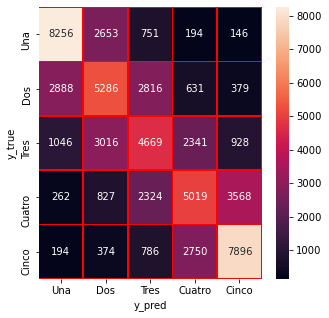

In [12]:
lr = LogisticRegression(C= 1, max_iter= 1000, multi_class= 'multinomial', penalty= 'l2', random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(accuracy_score(y_test, y_pred))
confusion(y_test,y_pred)

Podemos observar que el accuracy es similar al obtenido en el trabajo anterior y que tambien acierta en los extremos, complicandose mas en las calificaciones medias. Se esperaba que mejore ya que usamos la libreria Stanza para lematizar, pero no ha cumplido con las expectativas.

# Redes Neuronales

Procederemos a ver algunos conceptos claves de redes neuronales y luego implementaremos :

**Red Neuronal Artificial**: es un modelo de aprendizaje automático profundo con características similares al comportamiento de una red neuronal humana. Estas redes contienen nodos, como las neuronas en nuestro cerebro, que están interconectados entre sí siguiendo una estructura ordenada. Presentan una estructura en capas, dónde cada capa tiene funciones a desarrollar.

**Capa de entrada**: está formada por nuestros datos de entrada, las características con las cuales la red será capaz de aprender.

**Capas ocultas**: pueden existir varias capas ocultas. Acá es donde la red realiza diferentes cálculos y ajustes para arrojar los mejores resultados.

**Capa de salida**: presenta los resultados obtenidos luego del entrenamiento.

El número de capas de la red neuronal es un parámetro a definir. Al igual que número de neuronas que contiene cada capa.

**Función de activación**: en las capas ocultas se realizan una serie de cálculos que involucran pesos y sesgos generados, en principio, de forma aleatoria y luego van siendo ajustados durante el entrenamiento. La función de activación devuelve una salida que es generada por la neurona dada una entrada o un conjunto de entradas. Existen diversos tipos de función de activación y, dependiendo de sus características conviene o no usarlas.

En este desarrollo, utilizaremos 3 tipos de función de activación:

* **Función RELU**: permite el aprendizaje rápido en las redes neuronales. Si se le pasa un valor negativo asigna un cero, y si no, queda igual si el valor es positivo.
* **Función Softmax**: se usa para clasificar datos con múltiples clases. Asigna probabilidades de pertenencia de cada clase. Ésta función la usaremos para la clasificación de 1 a 5 estrellas.


**Optimizador**: es el encargado de generar pesos que presenten cada vez errores más pequeños. Usaremos en nuestro caso, el descenso por gradiente para disminuir la brecha de error entre los resultados calculados y los deseados.

**Función de pérdida**: nos permite calcular diferencia de error entre los resultados calculados y los deseados.

**Métrica**: nos indicará qué tan buenos son nuestros resultados.

## Librerias: Utilizaremos Tensorflow y keras

In [129]:
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from keras.models import Sequential
from plot_keras_history import plot_history
from keras.regularizers import l2
from keras.backend import clear_session
from tensorflow.keras.models import Sequential

C:\Users\Lucas\miniconda3\envs\dspln\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Lucas\miniconda3\envs\dspln\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Lucas\miniconda3\envs\dspln\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Lucas\miniconda3\envs\dspln\lib\site-packages\tensorflow\pyth

Defino una semilla para obtener resultados reproducibles. [Ref](https://machinelearningmastery.com/reproducible-results-neural-networks-keras/)

In [130]:
from numpy.random import seed

In [131]:
my_seed = 42
seed(my_seed)
tf.random.set_random_seed(1)
#tf.random.set_seed(my_seed)

Nuevamente vectorizamos con TF IDF y usamos train_test_split para dividir el dataset y entrenarlo

In [134]:
vectorizer = TfidfVectorizer(max_features= 2000, ngram_range = (1,2))
X = vectorizer.fit_transform(dataset_lem['reviews_lemma']).toarray().astype("float16")
y = dataset_lem.stars
print(X.shape)
print(y.shape)

(200000, 2000)
(200000,)


In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=dataset_lem.stars, random_state=my_seed)

## Parámetros del modelo

Configuraremos el modelo con los siguientes parámetros:

`modelo`: Sequential(), nos permite crear un modelo con una serie de capas de manera secuencial.

`número de capas`: Se trabajará con 6 capas, una de entrada, cuatro ocultas y una de salida. Se consideró crear la red con 6 capas, luego de varias iteraciones se encontraron mejores resultados. 

`input_dim`: la dimensión de las características de entrada es igual a la cantidad de atributos generados por el vectorizador.

`units`: la cantidad de neuronas por capas son 2000, 1000, 500, 100, 50 y 6, para el caso de múltiples clases. 

`activation`: 'relu' para las primeras 5 capas y 'softmax' para la útlima.

`kernel_regularizer`: usamos un regularizador que permita penalizar los parámetros de la capa durante la optimización y con ésto obtener mejores resultados. Se escoge la regularización de Ridge L2, con un alpha igual 0.001.

`loss`: 'sparse_categorical_crossentropy', se escoge ésta función de pérdida porque es la sugerida para múltiples clases. [ref](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy).

`optimizer`: 'sgd', se escoge descenso por gradiente 

`metrics`: 'accuracy', ya que las etiquetas están balanceadas. 

Para el ajuste del modelo:

`epochs`: 100, se escoge 100 épocas con la intención de observar el desempeño del conjunto de entrenamiento y testeo. De estar sobreajustado o no, se considerará modificar este parámetro. Representa la cantidad de iteraciones a realizar por el algoritmo. 

`batch_size`: El tamaño del lote lo escogemos igual a 100. Con esto alimentamos a la red con muestras más pequeñas que el conjunto de muestra original. 


In [138]:
max_features = 2000  # Número máximo de características generadas

model = Sequential()
model.add(layers.Dense(units=2000, input_dim=max_features, activation='relu')) #capa 1
model.add(layers.Dense(units=1000, input_dim=max_features, activation='relu',kernel_regularizer=l2(0.001))) #capa 2
model.add(layers.Dense(units=500, input_dim=max_features, activation='relu',kernel_regularizer=l2(0.001))) #capa 3
model.add(layers.Dense(units=100, input_dim=max_features, activation='relu',kernel_regularizer=l2(0.001))) #capa 4
model.add(layers.Dense(units=50, input_dim=max_features, activation='relu',kernel_regularizer=l2(0.001)))#capa 5
model.add(layers.Dense(6, activation='softmax')) #capa 6

Instructions for updating:
Colocations handled automatically by placer.


In [139]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='sgd', 
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2000)              4002000   
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_3 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 306       
Total params: 6,558,956
Trainable params: 6,558,956
Non-trainable params: 0
_________________________________________________________________


Entrenamos el modelo

In [163]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=100).history

Vemos los resultados

In [167]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Loss: {:.4f}".format(loss))
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Loss: {:.4f}".format(loss))
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Loss: 0.8847
Training Accuracy: 0.6333
Testing Loss: 1.5315
Testing Accuracy:  0.4448


Obtenemos un accuracy de 0.4448 en test, sin alcanzar el resultado en nuestro modelo benchmark de 0.5187 ni el mejor del trabajo anterior; y una pérdida de 1.5315. Veremos entonces cómo varía la pérdida y la precisión del modelo según el número de épocas. Para ésto utilizaremos el módulo `plot_history`, que nos mostrará el desempeño del modelo para los conjuntos de entrenamiento y testeo. 

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000015251248EB8>,
       dtype=object))

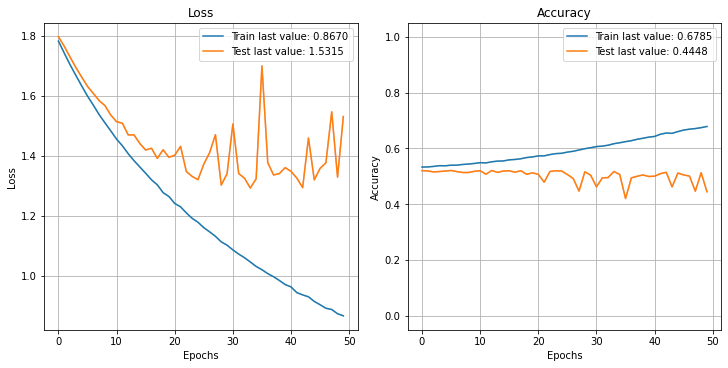

In [168]:
plot_history(history)

Se observa que a partir de la época 10 se empieza a notar una brecha más amplia entre el desempeño de los conjuntos de entrenamiento y testeo, lo cual indica que el modelo empieza a sobreajustarse.

### Ahora predecimos 

In [170]:
y_pred = model.predict_classes(X_test)
y_pred

array([4, 3, 3, ..., 1, 4, 3], dtype=int64)

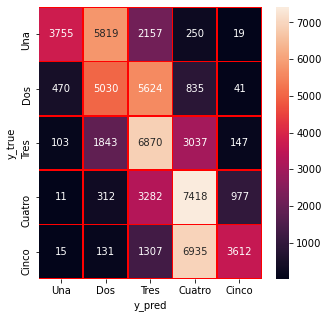

In [174]:
confusion(y_test,y_pred)

Aqui podemos observar que no acierta tanto en los extremos 1 y 5 como lo hacian nuestros modelos anteriores, y si acierta mas en las calificaciones medias, lo cual es muy interesante para tener en cuenta en analisis y modelos que se pueden generar posteriormente

# Conclusiones

Despues de realizar las tecnicas planteadas, no se ha mejorado la metrica seleccionada, pero me parecio muy interesante Top Modeling y pude desarrollarlo correctamente, al igual que la lematizacion con stanza y la aplicacion de una red neuronal (siendo esto de lo que mas aprendi y lo que me resulta mas interesante). Antes de realizarlo estimaba que mejoraria la metrica, y debo destacar que me tomo mucho trabajo computacional (6 horas la red neuronal y 12 horas la lematizacion con stanza). Tambien me parecio muy util utilizar nubes de palabras, ya que facilita el trabajo de entendimiento.
En cuanto a los resultados, si bien no se mejoro la metrica accuracy, como antes dije me parece util el hecho de mejorar la prediccion en las calificaciones medias, algo que no se habia logrado anteriormente.

# REPOSITORIO GIT-HUB

https://github.com/LucasCardenas/Acamica-proyectos/blob/46e024d373e1b3a8a0d97e7e3212864ce289faa1/Proyecto%204%20acamica.ipynb

Trabajo Anterior

https://github.com/LucasCardenas/Acamica-proyectos/blob/c5dddf63222f3fd22dcd8b0e3bb785612f135f07/Proyecto%203-%20Final.ipynb